In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import os
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
# os.chdir('drive/My Drive/Colab Notebooks/Numeraxial/data_cleaned')

# Get the path of current working directory 
path = os.getcwd() 
  
# Get the list of all files and directories 
# in current working directory 
dir_list = os.listdir(path) 
  
print("Files and directories in '", path, "' :")  
# print the list 
dir_list.sort()
print(dir_list)

# idx_pickle=[]
# idx_csv=[]
# list_all = os.listdir(os.path.join(path,'data'))
# for num, lst in enumerate(list_all):
#   if re.findall(r".pickle", lst) != []:
#     idx_pickle.append(num)
#   elif re.findall(r".csv", lst) != []:
#     idx_csv.append(num)

# pickle_set = []
# csv_set = []
# for i in idx_pickle:
#   pickle_set.append(list_all[i])
# for i in idx_csv:
#   csv_set.append(list_all[i])

# pickle_set.sort()
# csv_set.sort()
# print(pickle_set)
# print(csv_set)
# n = len(pickle_set)

Files and directories in ' /content/drive/My Drive/Colab Notebooks/Numeraxial/data_cleaned ' :
['AAPL.pkl', 'AXP.pkl', 'BA.pkl', 'CAT.pkl', 'CSCO.pkl', 'CVX.pkl', 'DIS.pkl', 'GE.pkl', 'GS.pkl', 'HD.pkl', 'IBM.pkl', 'INTC.pkl', 'JNJ.pkl', 'JPM.pkl', 'KO.pkl', 'MCD.pkl', 'MMM.pkl', 'MRK.pkl', 'MSFT.pkl', 'NKE.pkl', 'PFE.pkl', 'PG.pkl', 'TRV.pkl', 'UNH.pkl', 'UTX.pkl', 'V.pkl', 'VZ.pkl', 'WMT.pkl', 'XOM.pkl']


# Preprocessing

In [0]:
df = pd.read_pickle('AAPL.pkl')
df.head()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9763 entries, 2017-03-27 09:45:00-04:00 to 2018-06-13 16:00:00-04:00
Columns: 106 entries, Symbol to 99
dtypes: float64(104), int64(1), object(1)
memory usage: 8.0+ MB


In [27]:
# df.index.dt.format
fmt = "%Y-%m-%d %H:%M:%S"
df.index = df.index.strftime(fmt)
df.head()

# d = datetime.datetime.strptime(s, format)
# print 'strptime:', d.strftime(format)

,Symbol,Open,High,Low,Close,Volume,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-03-27 09:45:00,AAPL,139.42,140.00,139.26,139.85,959512,0.343900,0.318100,0.202833,0.451283,0.220767,0.097250,0.201217,0.257700,0.219067,0.165283,0.276617,0.137350,0.172100,0.448267,0.708650,0.226317,0.190483,0.3338,0.120800,0.147483,0.145117,0.193000,0.183167,0.183567,0.184133,0.128600,0.2239,0.128167,0.154233,0.367217,0.180700,0.150333,0.241983,0.300333,...,0.22595,0.16255,0.147417,0.219800,0.340,0.152317,0.207333,0.355950,0.117967,0.236667,0.184200,0.193400,0.15845,0.243783,0.133517,0.087300,0.304683,0.236967,0.241633,0.185433,0.154167,1.14795,0.169517,0.112750,0.218383,0.148167,2.09325,0.207067,0.181917,0.294200,0.157467,0.21175,0.225200,0.352883,0.30225,0.189067,0.273767,0.110617,0.28565,0.181733
2017-03-27 10:00:00,AAPL,139.89,140.00,139.10,139.96,521640,0.000000,0.556000,0.185000,0.314000,0.000000,0.385000,0.230000,1.013000,0.000000,0.264000,0.386000,0.660000,0.000000,0.169000,0.787000,0.213000,0.078000,0.1900,0.390000,0.485000,0.000000,0.519000,0.043000,0.000000,0.199000,0.736000,0.2260,0.277000,0.172000,0.077000,0.232000,0.134000,0.062000,0.986000,...,0.15000,0.16200,0.000000,0.617000,0.824,0.284000,0.000000,0.341000,0.076000,0.379000,0.133000,0.000000,0.00000,0.698000,0.348000,0.101000,0.662000,0.415000,0.347000,0.224000,0.000000,2.21100,0.398000,0.311000,0.421000,0.111000,2.96100,0.000000,0.795000,0.479000,0.000000,0.13800,0.185000,0.771000,0.71500,0.232000,0.382000,0.305000,0.02700,0.085000
2017-03-27 10:15:00,AAPL,140.01,140.28,140.01,140.24,184645,0.480000,0.328000,0.421000,0.174000,0.247000,0.146000,0.166000,0.771000,0.420000,0.165000,0.474000,0.119000,0.001000,1.515000,1.147000,0.432000,0.083000,0.1250,0.567000,0.300000,0.386000,0.667000,0.489000,0.193000,0.316000,0.267000,0.8010,0.064000,0.074000,0.311000,0.237000,0.518000,0.080000,0.227000,...,0.04700,0.20500,0.067000,0.077000,0.080,0.400000,0.408000,0.081000,0.094000,0.318000,0.309000,0.550000,0.24300,0.259000,0.437000,0.193000,0.092000,0.134000,1.061000,0.307000,0.158000,1.27500,0.287000,0.144000,0.242000,0.439000,2.81400,0.164000,0.160000,0.000000,0.049000,0.73000,0.102000,0.794000,0.04300,0.214000,0.583000,0.268000,0.37000,0.374000
2017-03-27 10:30:00,AAPL,140.13,140.42,140.10,140.28,631623,0.241000,0.480000,0.234000,0.065000,0.480000,0.097000,0.383000,0.049000,0.408000,0.352000,0.120000,0.116000,0.046000,0.171000,0.109000,0.225000,0.010000,0.2180,0.136000,0.353000,0.338000,0.426000,0.178000,0.220000,0.274000,0.088000,0.2820,0.064000,0.305000,0.531000,0.206000,0.087000,0.134000,0.264000,...,0.27200,0.15300,0.694000,0.290000,0.832,0.135000,0.060000,0.126000,0.094000,0.148000,0.413000,0.225000,0.09500,0.459000,0.076000,0.128000,0.092000,0.202000,0.155000,0.248000,0.193000,0.41500,0.231000,0.450000,0.398000,0.466000,1.06300,0.150000,0.541000,0.119000,0.125000,0.27000,0.139000,0.152000,0.31000,0.550000,0.221000,0.083000,0.06500,0.121000
2017-03-27 10:45:00,AAPL,140.46,140.50,140.36,140.46,374625,0.412667,0.240333,0.089000,0.202667,0.326000,0.090333,0.307000,0.180333,0.127000,0.054000,0.227000,0.107667,0.043333,0.701667,0.440667,0.129000,0.151667,0.1250,0.144333,0.134000,0.128333,0.188333,0.031333,0.075000,0.105000,0.280667,0.2560,0.064000,0.162667,0.432333,0.171333,0.225000,0.120667,0.109000,...,0.22900,0.14700,0.067000,0.115333,0.080,0.050000,0.094667,0.288333,0.156000,0.101667,0.226667,0.107333,0.09500,0.137667,0.076000,0.131333,0.139000,0.201667,0.081000,0.115000,0.196000,0.59800,0.024000,0.319333,0.237333,0.058000,1.42900,0.096333,0.175333,0.179333,0.149000,0.11200,0.288667,0.276667,0.08100,0.228000,0.056333,0.104333,0.38300,0.177667


In [110]:
# xy = np.array(df.iloc[:,1:], dtype=np.float32)
xy.shape

(9763, 105)

In [109]:
xy = np.array(df.iloc[:,1:], dtype=np.float32)
scaler = MinMaxScaler()
scaler.fit(xy[:,:5])
xy_pr=scaler.transform(xy[:,:5])
xy = np.concatenate((xy_pr, xy[:,5:]), axis = 1)
print(xy)

[[0.         0.         0.00291538 ... 0.11061667 0.28565    0.18173334]
 [0.00858927 0.         0.         ... 0.305      0.027      0.085     ]
 [0.01078224 0.00516605 0.01658154 ... 0.268      0.37       0.374     ]
 ...
 [0.9448099  0.94557214 0.94515324 ... 0.342      0.489      0.297     ]
 [0.94645476 0.94483423 0.93549585 ... 0.342      0.489      0.297     ]
 [0.9371345  0.95110726 0.94023323 ... 0.16333333 0.8796667  0.269     ]]


In [32]:
# xy = np.array(
#     [
#         [828.659973, 833.450012, 908100, 828.349976, 831.659973],
#         [823.02002, 828.070007, 1828100, 821.655029, 828.070007],
#         [819.929993, 824.400024, 1438100, 818.97998, 824.159973],
#         [816, 820.958984, 1008100, 815.48999, 819.23999],
#         [819.359985, 823, 1188100, 818.469971, 818.97998],
#         [819, 823, 1198100, 816, 820.450012],
#         [811.700012, 815.25, 1098100, 809.780029, 813.669983],
#         [809.51001, 816.659973, 1398100, 804.539978, 809.559998],
#     ]
# )

# def min_max_scaler(data):
#     numerator = data - np.min(data, 0)
#     denominator = np.max(data, 0) - np.min(data, 0)
#     # noise term prevents the zero division
#     return numerator / (denominator + 1e-7)# * (max-min) + min

# xy = min_max_scaler(xy)
# scaler = MinMaxScaler()
# scaler.fit(xy)
# xy=scaler.transform(xy)
print(xy[:,:5])

# '''
# [[0.99999999 0.99999999 0.         1.         1.        ]
#  [0.70548491 0.70439552 1.         0.71881782 0.83755791]
#  [0.54412549 0.50274824 0.57608696 0.606468   0.6606331 ]
#  [0.33890353 0.31368023 0.10869565 0.45989134 0.43800918]
#  [0.51436    0.42582389 0.30434783 0.58504805 0.42624401]
#  [0.49556179 0.42582389 0.31521739 0.48131134 0.49276137]
#  [0.11436064 0.         0.20652174 0.22007776 0.18597238]
#  [0.         0.07747099 0.5326087  0.         0.        ]]
# '''

[[8.28659973e+02 8.33450012e+02 9.08100000e+05 8.28349976e+02
  8.31659973e+02]
 [8.23020020e+02 8.28070007e+02 1.82810000e+06 8.21655029e+02
  8.28070007e+02]
 [8.19929993e+02 8.24400024e+02 1.43810000e+06 8.18979980e+02
  8.24159973e+02]
 [8.16000000e+02 8.20958984e+02 1.00810000e+06 8.15489990e+02
  8.19239990e+02]
 [8.19359985e+02 8.23000000e+02 1.18810000e+06 8.18469971e+02
  8.18979980e+02]
 [8.19000000e+02 8.23000000e+02 1.19810000e+06 8.16000000e+02
  8.20450012e+02]
 [8.11700012e+02 8.15250000e+02 1.09810000e+06 8.09780029e+02
  8.13669983e+02]
 [8.09510010e+02 8.16659973e+02 1.39810000e+06 8.04539978e+02
  8.09559998e+02]]


In [111]:
print(int(len(xy) * .9))
print(len(xy))

8786
9763


In [0]:
split_time1 = int(len(xy) * .7)
split_time2 = int(len(xy) * .9)
train_set = xy[:split_time1,:]
valid_set = xy[split_time1:split_time2,:]
test_set = xy[split_time2:,:]


x_train = train_set[:,1:]
y_train = train_set[:,0]
x_val = valid_set[:,1:]
y_val = valid_set[:,0]
x_test = test_set[:,1:]
y_test = test_set[:,0]

y_train = y_train.reshape(-1,1).astype(np.float32)
y_val = y_val.reshape(-1,1).astype(np.float32)
y_test = y_test.reshape(-1,1).astype(np.float32)

In [113]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(6834, 104)
(6834, 1)
(1952, 104)
(1952, 1)
(977, 104)
(977, 1)


In [131]:
x_train

array([[0.        , 0.00291538, 0.        , ..., 0.11061667, 0.28565   ,
        0.18173334],
       [0.        , 0.        , 0.00202823, ..., 0.305     , 0.027     ,
        0.085     ],
       [0.00516605, 0.01658154, 0.00719142, ..., 0.268     , 0.37      ,
        0.374     ],
       ...,
       [0.5182657 , 0.5102043 , 0.51687264, ..., 0.367     , 0.332     ,
        0.128     ],
       [0.52029514, 0.5102043 , 0.50838995, ..., 0.268     , 0.3658    ,
        0.3558    ],
       [0.51107025, 0.5102043 , 0.5045178 , ..., 0.268     , 0.3658    ,
        0.3558    ]], dtype=float32)

# Support Vector Machine

In [135]:
from sklearn.svm import SVR

# svr_lin = SVR(kernel = 'linear', C=1e3)
svr_rbf = SVR(kernel = 'rbf', C=1e3)

# svr_lin.fit(df[['Open','High','Low']], df['Close'])
# svr_rbf.fit(df[['Open','High','Low']], df['Close'])
# print(svr_lin.score(df[['Open','High','Low']], df['Close']))
# print(svr_poly.score(df[['Open','High','Low']], df['Close']))

svr_rbf.fit(x_train, y_train)
print(svr_rbf.score(x_train,y_train))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9226747442201206


In [178]:
print(np.array(svr_rbf.predict(x_train)))#.reshape(-1,1))
print(y_train.reshape(-1,))

[0.06209904 0.10867713 0.09633546 ... 0.47117071 0.4782449  0.47462921]
[0.         0.00858927 0.01078224 ... 0.51279235 0.51918864 0.5118785 ]


In [160]:
tf.keras.metrics.mean_squared_error(np.array([[1],[2],[3],[4]]),np.array([2,0.4,4,3])).numpy()

array([3.59, 1.89, 2.19, 4.49])

In [183]:
print(svr_rbf.score(x_train,y_train))
print(svr_rbf.score(x_test,y_test))

0.9226747442201206
-5.0643926756267685


In [180]:
tf.keras.metrics.mean_squared_error(y_train.reshape(-1,), np.array(svr_rbf.predict(x_train))).numpy()

0.003123169246432374

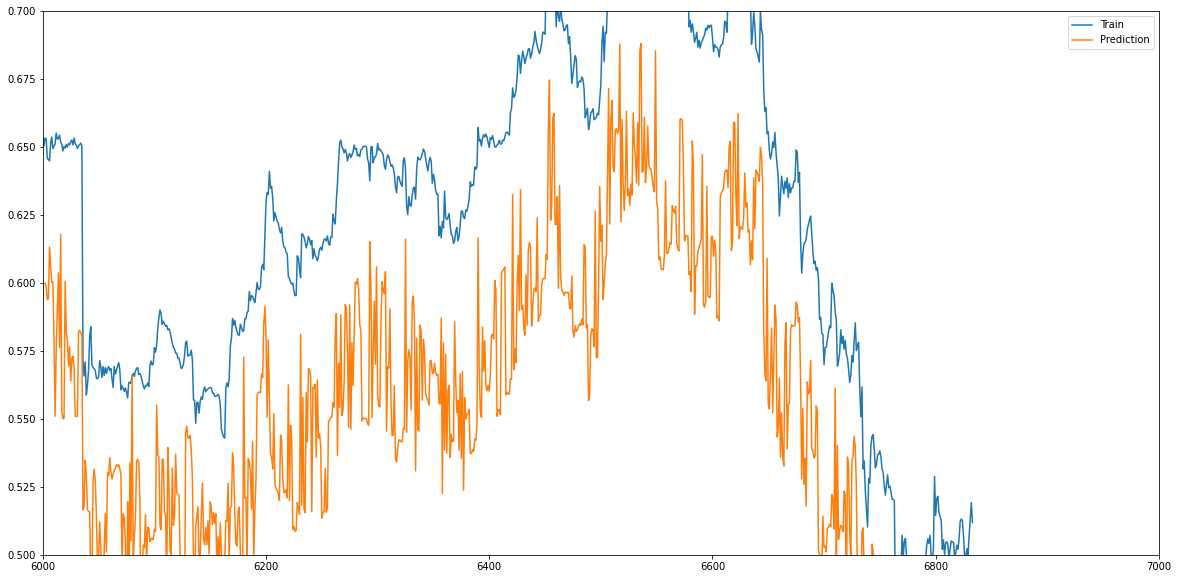

In [142]:
plt.figure(figsize=(20,10))
plt.plot(y_train, label = 'Train')
plt.plot(svr_rbf.predict(x_train), label = 'Prediction')
plt.xlim(6000,7000)
plt.ylim(.5,.7)
plt.legend()


# plt.plot(svr_lin.predict(df.loc[:,['Open','High','Low']].values), label = 'Linear')
# #plt.plot(svr_poly.predict(df_new.loc[:,['Open','High','Low']].values), label = 'Poly')
# plt.plot(svr_rbf.predict(df.loc[:,['Open','High','Low']].values), label = 'Rbf')
# plt.legend()

In [123]:
df['Close'].values

array([139.85, 139.96, 140.24, ..., 191.21, 190.71, 190.71])

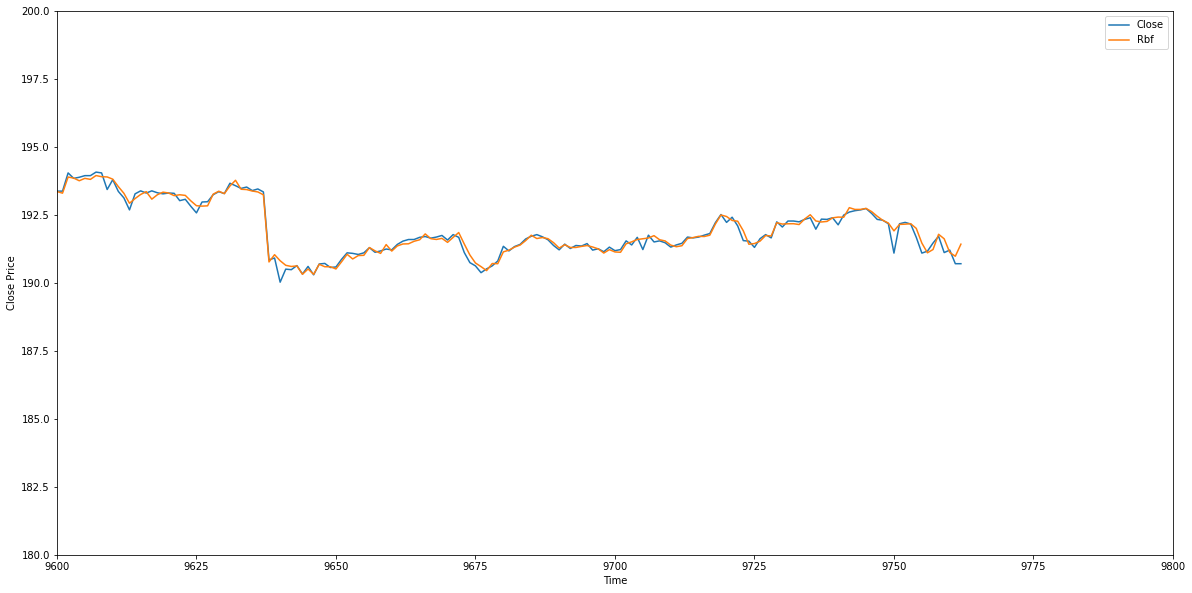

In [130]:
%matplotlib inline

plt.figure(figsize=(20,10))
plt.plot(df['Close'].values, label = 'Close')
plt.plot(svr_rbf.predict(df.loc[:,['Open','High','Low']].values), label = 'Rbf')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.xlim(9600,9800)
plt.ylim(180,200)
plt.legend()

# Neural Network
regularization l2: .01

kernel regularization max-norm: max_value=1

dropout: .5

Ne for first layer: [64, 128, 256]

learning rate: [.001, .0001]

Adam: epsilon=10e-08, beta1=.9, beta2=.999


In [115]:
random.seed(777)  # for reproducibility
learning_rate = 0.001
# learning_rate = [0.001, .0001]
l2_reg = .01
max_value = 1
batch_size = 100
training_epochs = 100
# nb_classes = 10
drop_rate = .5
# Ne = [64, 128, 256]
Ne = 128


# smote = SMOTE()
# X_train_smote, Y_train_smote = smote.fit_sample(x_train,y_train)
# X_val_smote, Y_val_smote = smote.fit_sample(x_val,y_val)


# y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
# y_test = tf.keras.utils.to_categorical(y_test, nb_classes)

model = tf.keras.Sequential([
                             tf.keras.layers.Dense(Ne, input_shape=(104,), activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(drop_rate),
                             tf.keras.layers.Dense(Ne/2, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(drop_rate),
                             tf.keras.layers.Dense(Ne/4, activation=tf.keras.layers.LeakyReLU(), kernel_initializer='glorot_normal'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(drop_rate),
                             tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer='glorot_normal')                             
])

model.compile(loss= 'mse',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),#, epsilon=epsilon),#beta_1=beta1, beta_2=beta2, ),
              metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    verbose = 1,
                    epochs=training_epochs,
                    validation_data=(x_val,y_val)
                    )

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 128)               13440     
_________________________________________________________________
batch_normalization_51 (Batc (None, 128)               512       
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_52 (Batc (None, 64)                256       
_________________________________________________________________
dropout_52 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 32)              

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Random Forest

# Clean Up
Before running the next exercise, run the following cell to terminate the kernel and free memory resources:

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)